In [19]:
import numpy as np
from scipy.stats import norm
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from matplotlib import cm

# 1 PDE Methods: Binary and Barrier Options

# Binary options

## 3.Use Monte carlo to compute the price of a binary option to its closed form solution

### Define the function for the closed form solution

In [37]:
def closed_form_binary(S0,K,T,r,sigma):
    d_minus=((r-0.5*sigma**2)*T+np.log(S0/K)) / (sigma * np.sqrt(T))
    return np.exp(-r * T) * norm.cdf(d_minus)

### Define the function for the monte carlo simulation estimator

In [38]:
def monte_carlo_binary(S0,K,T,r,sigma,M):
    np.random.seed(42)
    Z = np.random.randn(M)
    ST = S0 * np.exp(sigma*np.sqrt(T)*Z+(r-0.5*sigma**2)*T)
    payoff = (ST >= K).astype(float)
    price = np.exp(-r*T)*np.mean(payoff)
    variance = np.var(payoff,ddof=1)
    rmse = np.sqrt(variance/M)
    return price,rmse

In [119]:
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
M = 100000

closed_form_price = closed_form_binary(S0,K,T,r,sigma)
mc_price, rmse = monte_carlo_binary(S0,K,T,r,sigma,M)

print(f"Closed-form price: {closed_form_price:.6f}")
print(f"Monte Carlo price: {mc_price:.6f}")
print(f"Monte Carlo RMSE : ±{rmse:.6f}")
print(f"Absolute Error   : {abs(mc_price-closed_form_price):.6f}")


Closed-form price: 0.532325
Monte Carlo price: 0.532812
Monte Carlo RMSE : ±0.001570
Absolute Error   : 0.000487


## 4.Use the implicit discretization scheme and the Crank Nicolson scheme to price a binary/digital options. Make also a sensitivity analysis on the parameter space and plot the digital option surface c(S, t). Finally compute the delta as a function of the underlying S.

## Implicit Discretization Scheme

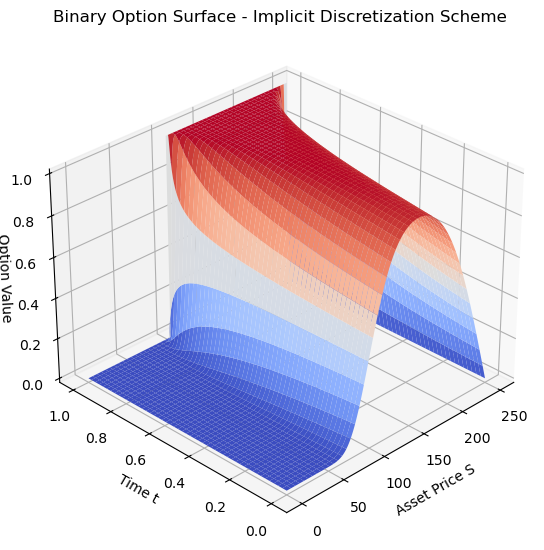

0.46141298930063085

In [129]:
def binary_option_implicit_scheme(S0, K, T, r, sigma, S_max=250, M=2000, N=2000):
    dS = S_max / N
    dt = T / M
    S = np.linspace(0, S_max, N + 1)
    t = np.linspace(0, T, M + 1)
    V = np.zeros((M + 1, N + 1))

    V[-1, S >= K] = 1.0

    j = np.arange(1, N)
    Sj = j * dS
    lambda_j = 0.5 * dt * sigma**2 * Sj**2 / dS**2

    lower = -lambda_j[1:]
    main = 1 + 2 * lambda_j
    upper = -lambda_j[:-1]
    A = sp.diags([lower, main, upper], offsets=[-1, 0, 1], shape=(N - 1, N - 1), format="csc")

    for n in reversed(range(M)):
        #V[n, 0] = 0.0     # Dirichlet BC at S = 0
        #V[n, -1] = 1.0    # Dirichlet BC at S = S_max
        V[n, 1:N] = spla.spsolve(A, V[n + 1, 1:N])
        
    price = np.interp(S0, S, V[0, :])
    return price, S, t, V

price_implicit_scheme, S_imp, t_imp, V_imp = binary_option_implicit_scheme(S0, K, T, r, sigma)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
T_grid, S_grid = np.meshgrid(t_imp, S_imp)
ax.plot_surface(S_grid, T_grid, V_imp.T, cmap=cm.coolwarm)
ax.set_title("Binary Option Surface - Implicit Discretization Scheme")
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Option Value", labelpad=0)
ax.view_init(elev=30, azim=225)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
plt.show()

price_implicit_scheme


## CN Scheme

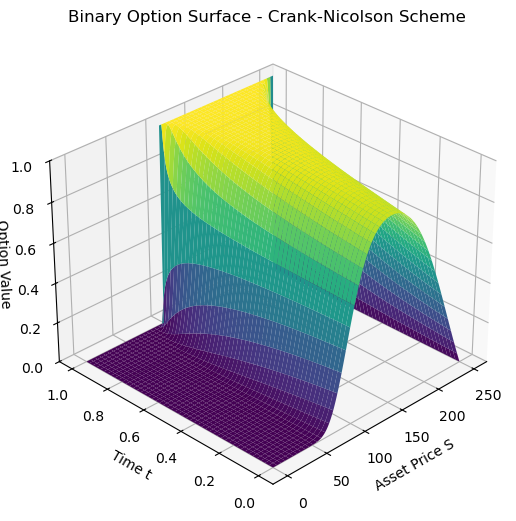

0.5334889089827624

In [130]:
def binary_option_crank_nicolson_scheme(S0, K, T, r, sigma, S_max=250, M=2000, N=2000):
    dS = S_max / N
    dt = T / M
    S = np.linspace(0, S_max, N + 1)
    t = np.linspace(0, T, M + 1)
    V = np.zeros((M + 1, N + 1))

    V[-1, S >= K] = 1.0

    j = np.arange(1, N)
    Sj = j * dS

    a = 0.25 * dt * (sigma**2 * Sj**2 / dS**2 - r * Sj / dS)
    b = -0.5 * dt * (sigma**2 * Sj**2 / dS**2 + r)
    c = 0.25 * dt * (sigma**2 * Sj**2 / dS**2 + r * Sj / dS)

    A_lower = -a[1:]
    A_main = 1 - b
    A_upper = -c[:-1]
    A = sp.diags([A_lower, A_main, A_upper], offsets=[-1, 0, 1], format="csc")

    B_lower = a[1:]
    B_main = 1 + b
    B_upper = c[:-1]
    B = sp.diags([B_lower, B_main, B_upper], offsets=[-1, 0, 1], format="csc")

    for n in reversed(range(M)):
        RHS = B @ V[n + 1, 1:N]
        V[n, 1:N] = spla.spsolve(A, RHS)

    price = np.interp(S0, S, V[0, :])
    return price, S, t, V

price_cn_scheme, S_cn, t_cn, V_cn = binary_option_crank_nicolson_scheme(S0, K, T, r, sigma)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
T_grid, S_grid = np.meshgrid(t_cn, S_cn)
ax.plot_surface(S_grid, T_grid, V_cn.T, cmap=cm.viridis)
ax.set_title("Binary Option Surface - Crank-Nicolson Scheme")
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Option Value", labelpad=0)
ax.set_zlim(0, 1)
ax.view_init(elev=30, azim=225)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

price_cn_scheme


## Sensitivity Analysis

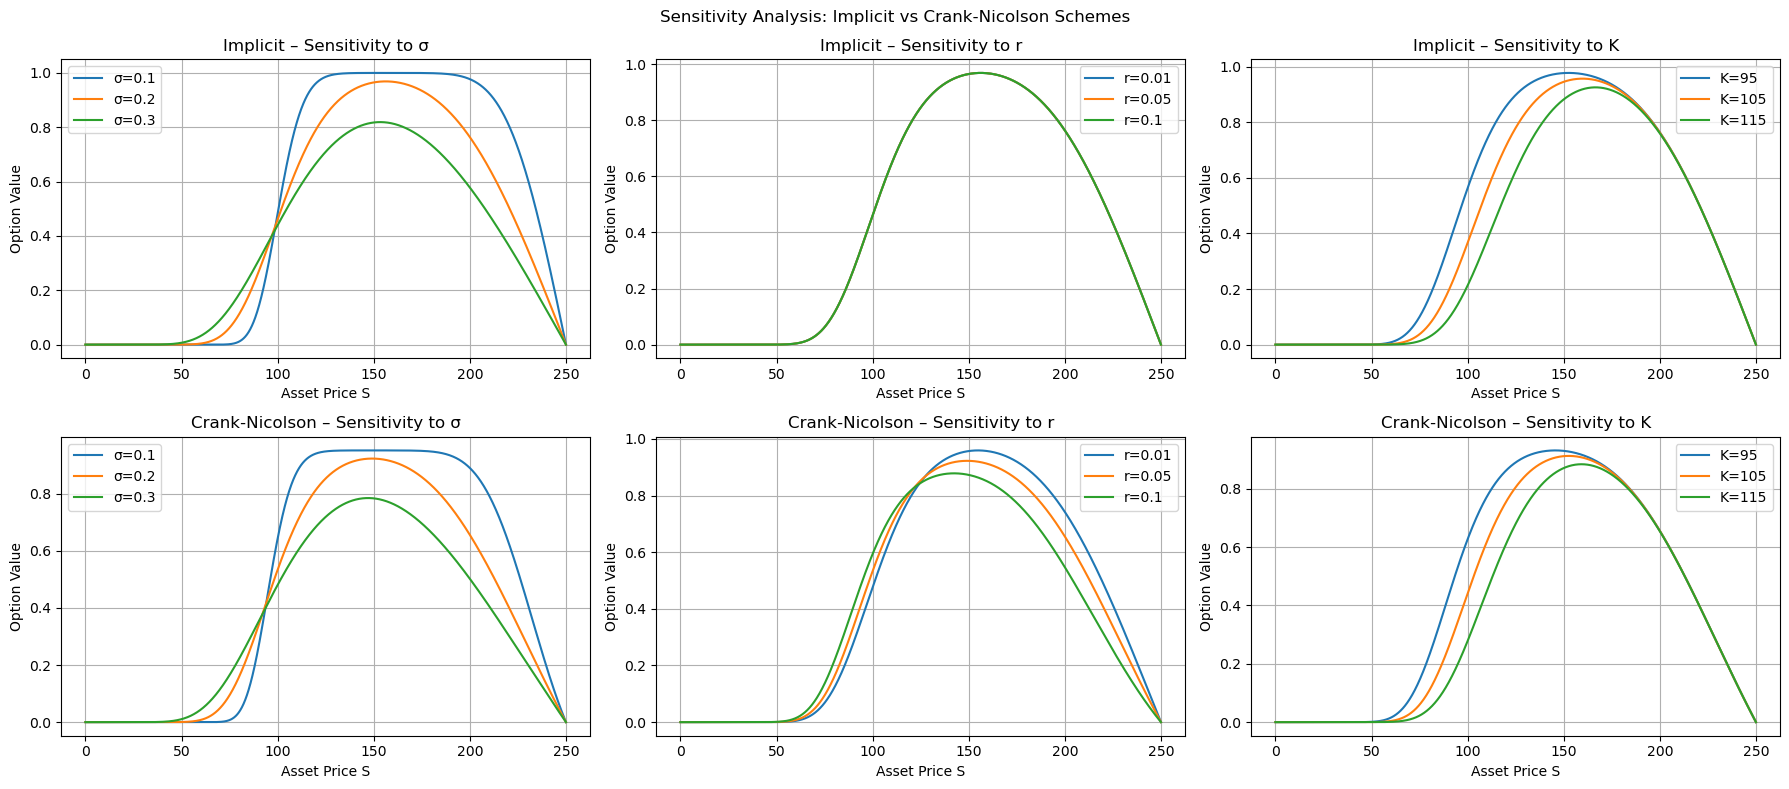

In [122]:
def sensitivity_analysis_comparison():
    S0 = 100
    T = 1.0
    base_r = 0.05
    base_sigma = 0.2
    base_K = 100

    sigmas = [0.1, 0.2, 0.3]
    rs = [0.01, 0.05, 0.1]
    Ks = [95, 105, 115]

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    methods = {
        "Implicit": binary_option_implicit_scheme,
        "Crank-Nicolson": binary_option_crank_nicolson_scheme
    }

    for idx, (label, method) in enumerate(methods.items()):
        # σ sensitivity
        for sigma in sigmas:
            _, S_sens, _, V_sens = method(S0, base_K, T, base_r, sigma)
            axes[idx, 0].plot(S_sens, V_sens[0], label=f"σ={sigma}")
        axes[idx, 0].set_title(f"{label} – Sensitivity to σ")
        axes[idx, 0].set_xlabel("Asset Price S")
        axes[idx, 0].set_ylabel("Option Value")
        axes[idx, 0].legend()
        axes[idx, 0].grid(True)

        # r sensitivity
        for r in rs:
            _, S_sens, _, V_sens = method(S0, base_K, T, r, base_sigma)
            axes[idx, 1].plot(S_sens, V_sens[0], label=f"r={r}")
        axes[idx, 1].set_title(f"{label} – Sensitivity to r")
        axes[idx, 1].set_xlabel("Asset Price S")
        axes[idx, 1].set_ylabel("Option Value")
        axes[idx, 1].legend()
        axes[idx, 1].grid(True)

        # K sensitivity
        for K in Ks:
            _, S_sens, _, V_sens = method(S0, K, T, base_r, base_sigma)
            axes[idx, 2].plot(S_sens, V_sens[0], label=f"K={K}")
        axes[idx, 2].set_title(f"{label} – Sensitivity to K")
        axes[idx, 2].set_xlabel("Asset Price S")
        axes[idx, 2].set_ylabel("Option Value")
        axes[idx, 2].legend()
        axes[idx, 2].grid(True)

    plt.suptitle("Sensitivity Analysis: Implicit vs Crank-Nicolson Schemes")
    plt.tight_layout()
    plt.show()

sensitivity_analysis_comparison()


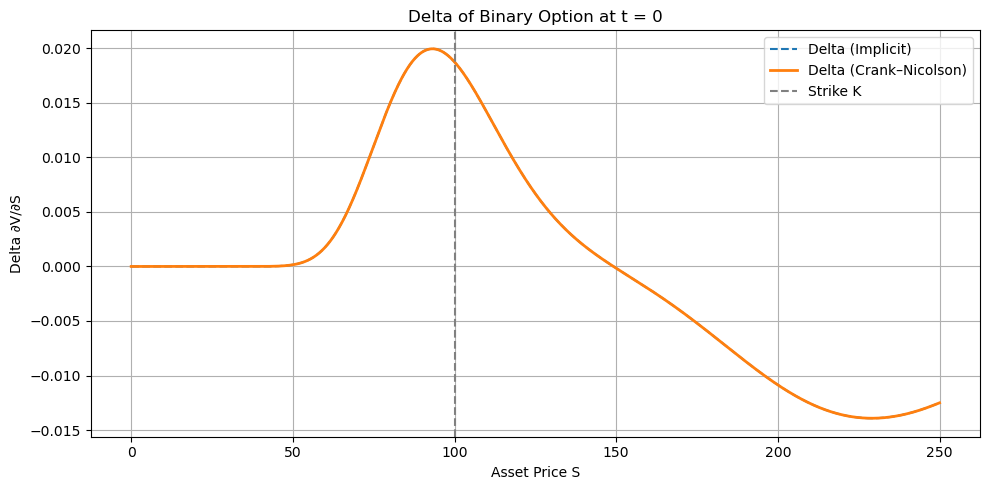

In [123]:
price_implicit, S_implicit, t_implicit, V_implicit = binary_option_crank_nicolson_scheme(S0, K, T, r, sigma)
price_cn, S_cn, t_cn, V_cn = binary_option_crank_nicolson_scheme(S0, K, T, r, sigma)

def compute_delta(S, V_row):
    delta = np.zeros_like(V_row)
    delta[1:-1] = (V_row[2:] - V_row[:-2]) / (2 * (S[1] - S[0]))
    delta[0] = (V_row[1] - V_row[0]) / (S[1] - S[0])
    delta[-1] = (V_row[-1] - V_row[-2]) / (S[1] - S[0])
    return delta

delta_implicit = compute_delta(S_implicit, V_implicit[0])
delta_cn = compute_delta(S_cn, V_cn[0])

plt.figure(figsize=(10, 5))
plt.plot(S_implicit, delta_implicit, label="Delta (Implicit)", linestyle="--")
plt.plot(S_cn, delta_cn, label="Delta (Crank–Nicolson)", linewidth=2)
plt.axvline(K, color="gray", linestyle="--", label="Strike K")
plt.xlabel("Asset Price S")
plt.ylabel("Delta ∂V/∂S")
plt.title("Delta of Binary Option at t = 0")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()